# Imports

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.neighbors import NearestNeighbors

from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
    precision_recall_curve,
    confusion_matrix,
    roc_curve
)

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import joblib
import yaml
from tqdm import tqdm

np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)


# 01 - build_features.py

In [2]:
DATA_PATH = "../data/NA_wildlife_agency_CWD_surveillance_data_2000_2022_v2.csv"

def load_data(path=DATA_PATH):
    df = pd.read_csv(path)
    df = df.sort_values(by="Season_year").reset_index(drop=True)
    return df

def prepare_features(df):
    df["positivity_rate"] = df["Tests_positive"] / (
        df["Tests_positive"] + df["Tests_negative"]
    )
    df["harvest_per_km2"] = (df["Total_harvest"] / df["Area"]).replace([np.inf, -np.inf], 0)
    df["tests_per_km2"] = (
        (df["Tests_positive"] + df["Tests_negative"]) / df["Area"]
    ).replace([np.inf, -np.inf], 0)
    df = df.fillna(0)

    y = df["Management_area_positive"].astype(int)

    drop_cols = [
        "Management_area_ID",
        "Management_area",
        "Administrative_area",
        "Latitude",
        "Longitude",
        "Season_year",
        "Area",
        "Management_area_positive",
    ]
    df_numeric = df.drop(columns=[c for c in drop_cols if c in df.columns])
    df_numeric = df_numeric.select_dtypes(include=["number"]).copy()
    X = df_numeric

    year_str = df["Season_year"].astype(str).str[:4]
    year_num = pd.to_numeric(year_str, errors="coerce")

    train_df = df[year_num <= 2019]
    val_df = df[year_num == 2020]
    test_df = df[year_num >= 2021]

    print("Data Split Summary")
    for name, subset in [("Train", train_df), ("Val", val_df), ("Test", test_df)]:
        pos_rate = subset["Management_area_positive"].mean()
        print(f"{name}: {len(subset)} rows | Pos rate: {pos_rate:.3f}")
    print("Done")

    return X, y, train_df, val_df, test_df

df = load_data()
X, y, train_df, val_df, test_df = prepare_features(df)


Data Split Summary
Train: 28760 rows | Pos rate: 0.015
Val: 1438 rows | Pos rate: 0.065
Test: 1438 rows | Pos rate: 0.065
Done


# 02 - train_logreg.py

In [3]:
from sklearn.feature_selection import VarianceThreshold

def train_logreg(X_train, y_train):
    X_train = X_train.apply(pd.to_numeric, errors="coerce").fillna(0.0)

    vt = VarianceThreshold(threshold=0.0)
    X_train_vt = vt.fit_transform(X_train)

    scaler = StandardScaler()
    X_train_std = scaler.fit_transform(X_train_vt)

    clf = LogisticRegression(penalty="l2", solver="liblinear")
    clf.fit(X_train_std, y_train)

    return clf, scaler, vt


def predict_logreg(model, scaler, vt, X):
    X = X.apply(pd.to_numeric, errors="coerce").fillna(0.0)
    X_vt = vt.transform(X)
    X_std = scaler.transform(X_vt)
    probs = model.predict_proba(X_std)[:, 1]
    preds = (probs >= 0.5).astype(int)
    return preds, probs


df = load_data(DATA_PATH)
X, y, train_df, val_df, test_df = prepare_features(df)

cut = int(len(X) * 0.8)
X_train, X_test = X.iloc[:cut], X.iloc[cut:]
y_train, y_test = y.iloc[:cut], y.iloc[cut:]

logreg_model, logreg_scaler, logreg_vt = train_logreg(X_train, y_train)
logreg_preds, logreg_probs = predict_logreg(logreg_model, logreg_scaler, logreg_vt, X_test)

precision = precision_score(y_test, logreg_preds)
recall = recall_score(y_test, logreg_preds)
f1 = f1_score(y_test, logreg_preds)
roc_auc = roc_auc_score(y_test, logreg_probs)
ap = average_precision_score(y_test, logreg_probs)
cm = confusion_matrix(y_test, logreg_preds)

print("Logistic Regression results:")
print(f"  Precision: {precision:.3f}")
print(f"  Recall:    {recall:.3f}")
print(f"  F1-score:  {f1:.3f}")
print(f"  ROC AUC:   {roc_auc:.3f}")
print(f"  PR AUC:    {ap:.3f}")
print("  Confusion matrix:")
print(cm)


Data Split Summary
Train: 28760 rows | Pos rate: 0.015
Val: 1438 rows | Pos rate: 0.065
Test: 1438 rows | Pos rate: 0.065
Done
Logistic Regression results:
  Precision: 0.890
  Recall:    0.476
  F1-score:  0.620
  ROC AUC:   0.739
  PR AUC:    0.564
  Confusion matrix:
[[5950   21]
 [ 187  170]]


# 03 - train_rf.py


In [4]:
def train_rf(X_train, y_train):
    X_train = X_train.apply(pd.to_numeric, errors="coerce").fillna(0.0)

    rf = RandomForestClassifier(
        n_estimators=500,
        max_depth=10,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1,
    )
    rf.fit(X_train, y_train)
    return rf


def predict_rf(model, X):
    X = X.apply(pd.to_numeric, errors="coerce").fillna(0.0)
    probs = model.predict_proba(X)[:, 1]
    return probs


df = load_data(DATA_PATH)
X, y, train_df, val_df, test_df = prepare_features(df)

n = len(X)
train_end = int(n * 0.6)
val_end = int(n * 0.8)

X_train, X_val, X_test = X.iloc[:train_end], X.iloc[train_end:val_end], X.iloc[val_end:]
y_train, y_val, y_test = y.iloc[:train_end], y.iloc[train_end:val_end], y.iloc[val_end:]

rf_model = train_rf(X_train, y_train)

val_probs = predict_rf(rf_model, X_val)
val_pr_auc = average_precision_score(y_val, val_probs)
val_roc_auc = roc_auc_score(y_val, val_probs)

precisions, recalls, thresholds = precision_recall_curve(y_val, val_probs)
f1_scores = 2 * precisions[:-1] * recalls[:-1] / (precisions[:-1] + recalls[:-1] + 1e-8)

if len(f1_scores) > 0:
    best_idx = int(np.argmax(f1_scores))
    best_thresh = float(thresholds[best_idx])
    val_f1 = float(f1_scores[best_idx])
    val_prec = float(precisions[best_idx])
    val_rec = float(recalls[best_idx])
else:
    best_thresh = 0.5
    val_pred = (val_probs >= best_thresh).astype(int)
    val_prec = precision_score(y_val, val_pred, zero_division=0)
    val_rec = recall_score(y_val, val_pred, zero_division=0)
    val_f1 = f1_score(y_val, val_pred, zero_division=0)

print("Validation (Random Forest):")
print(f"  PR-AUC = {val_pr_auc:.3f}, ROC-AUC = {val_roc_auc:.3f}")
print(f"  Best F1 = {val_f1:.3f} at threshold τ = {best_thresh:.3f}")
print(f"    Precision = {val_prec:.3f}, Recall = {val_rec:.3f}")

test_probs = predict_rf(rf_model, X_test)
test_pr_auc = average_precision_score(y_test, test_probs)
test_roc_auc = roc_auc_score(y_test, test_probs)
test_pred = (test_probs >= best_thresh).astype(int)
test_prec = precision_score(y_test, test_pred, zero_division=0)
test_rec = recall_score(y_test, test_pred, zero_division=0)
test_f1 = f1_score(y_test, test_pred, zero_division=0)

print(f"\nTest (Random Forest, τ = {best_thresh:.3f} from validation):")
print(f"  PR-AUC = {test_pr_auc:.3f}, ROC-AUC = {test_roc_auc:.3f}")
print(f"  F1 = {test_f1:.3f}  (Precision = {test_prec:.3f}, Recall = {test_rec:.3f})")


Data Split Summary
Train: 28760 rows | Pos rate: 0.015
Val: 1438 rows | Pos rate: 0.065
Test: 1438 rows | Pos rate: 0.065
Done
Validation (Random Forest):
  PR-AUC = 0.890, ROC-AUC = 0.996
  Best F1 = 0.829 at threshold τ = 0.452
    Precision = 0.829, Recall = 0.829

Test (Random Forest, τ = 0.452 from validation):
  PR-AUC = 0.571, ROC-AUC = 0.766
  F1 = 0.578  (Precision = 0.633, Recall = 0.532)


# 04 - train_mlp.py


In [5]:
# Improved tabular MLP for CWD risk (scaled features, tuned, early stopping)

H1 = 64
H2 = 32
DROPOUT = 0.2
BATCH_SIZE = 256
LR = 1e-4
MAX_EPOCHS = 150
PATIENCE = 10
MAX_GRAD_NORM = 5.0

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class CWDRiskMLPImproved(nn.Module):
    def __init__(self, in_dim, h1=H1, h2=H2, dropout=DROPOUT):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.fc3 = nn.Linear(h2, 1)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(dropout)

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.drop(x)
        x = self.relu(self.fc2(x))
        x = self.drop(x)
        return self.fc3(x).squeeze(-1)


def train_mlp(X_train, y_train, X_val, y_val, X_test, y_test):
    # numeric conversion + impute
    X_train = X_train.apply(pd.to_numeric, errors="coerce").fillna(0.0)
    X_val = X_val.apply(pd.to_numeric, errors="coerce").fillna(0.0)
    X_test = X_test.apply(pd.to_numeric, errors="coerce").fillna(0.0)

    # scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    # tensors
    X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
    X_val_t = torch.tensor(X_val_scaled, dtype=torch.float32)
    X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_train_t = torch.tensor(y_train.astype(np.float32).values)
    y_val_t = torch.tensor(y_val.astype(np.float32).values)
    y_test_t = torch.tensor(y_test.astype(np.float32).values)

    train_ds = TensorDataset(X_train_t, y_train_t)
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)

    # class weighting
    pos = float((y_train == 1).sum())
    neg = float((y_train == 0).sum())
    pos_weight = min(neg / max(pos, 1.0), 10.0)
    pos_weight_t = torch.tensor([pos_weight], dtype=torch.float32).to(DEVICE)

    model = CWDRiskMLPImproved(in_dim=X_train_t.shape[1]).to(DEVICE)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_t)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)

    best_val_pr = -np.inf
    best_state = None
    epochs_no_improve = 0
    mlp_train_losses, mlp_val_losses = [], []

    for epoch in range(1, MAX_EPOCHS + 1):
        model.train()
        running_loss = 0.0

        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)
            optimizer.step()
            running_loss += loss.item() * xb.size(0)

        avg_train_loss = running_loss / len(train_ds)
        mlp_train_losses.append(avg_train_loss)

        # validation
        model.eval()
        with torch.no_grad():
            val_logits = model(X_val_t.to(DEVICE))
            val_loss = criterion(val_logits, y_val_t.to(DEVICE)).item()
            mlp_val_losses.append(val_loss)
            val_probs = torch.sigmoid(val_logits).cpu().numpy()

        val_pr_auc = average_precision_score(y_val, val_probs)
        val_roc_auc = roc_auc_score(y_val, val_probs)

        print(f"Epoch {epoch:03d}: TrainLoss={avg_train_loss:.4f}, "
              f"ValLoss={val_loss:.4f}, Val PR-AUC={val_pr_auc:.4f}, Val ROC-AUC={val_roc_auc:.4f}")

        if val_pr_auc > best_val_pr + 1e-6:
            best_val_pr = val_pr_auc
            best_state = {k: v.detach().clone() for k, v in model.state_dict().items()}
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= PATIENCE:
                print(f"Early stopping at epoch {epoch} (no PR-AUC improvement for {PATIENCE} epochs).")
                break

    # load best model
    if best_state is not None:
        model.load_state_dict(best_state)

    # F1-optimal threshold on validation
    model.eval()
    with torch.no_grad():
        val_logits = model(X_val_t.to(DEVICE))
        val_probs = torch.sigmoid(val_logits).cpu().numpy()

    precisions, recalls, thresholds = precision_recall_curve(y_val, val_probs)
    f1_scores = 2 * precisions[:-1] * recalls[:-1] / (precisions[:-1] + recalls[:-1] + 1e-8)

    if len(f1_scores) > 0:
        best_idx = int(np.argmax(f1_scores))
        best_thresh = float(thresholds[best_idx])
    else:
        best_thresh = 0.5

    # test metrics
    with torch.no_grad():
        test_logits = model(X_test_t.to(DEVICE))
        test_probs = torch.sigmoid(test_logits).cpu().numpy()

    test_pred = (test_probs >= best_thresh).astype(int)
    print(f"\nFinal test evaluation done with τ = {best_thresh:.3f}")

    return model, scaler, best_thresh, test_probs, mlp_train_losses, mlp_val_losses


# run MLP end-to-end
df = load_data(DATA_PATH)
X, y, train_df, val_df, test_df = prepare_features(df)

n = len(X)
train_end = int(n * 0.6)
val_end = int(n * 0.8)
X_train, X_val, X_test = X.iloc[:train_end], X.iloc[train_end:val_end], X.iloc[val_end:]
y_train, y_val, y_test = y.iloc[:train_end], y.iloc[train_end:val_end], y.iloc[val_end:]

mlp_model, mlp_scaler, mlp_threshold, mlp_test_probs, mlp_train_losses, mlp_val_losses = train_mlp(
    X_train, y_train, X_val, y_val, X_test, y_test
)


Data Split Summary
Train: 28760 rows | Pos rate: 0.015
Val: 1438 rows | Pos rate: 0.065
Test: 1438 rows | Pos rate: 0.065
Done
Epoch 001: TrainLoss=0.6667, ValLoss=0.3802, Val PR-AUC=0.4338, Val ROC-AUC=0.8203
Epoch 002: TrainLoss=0.5524, ValLoss=0.3424, Val PR-AUC=0.5390, Val ROC-AUC=0.8489
Epoch 003: TrainLoss=0.4110, ValLoss=0.3337, Val PR-AUC=0.5910, Val ROC-AUC=0.8652
Epoch 004: TrainLoss=0.3487, ValLoss=0.3200, Val PR-AUC=0.6337, Val ROC-AUC=0.8794
Epoch 005: TrainLoss=0.2830, ValLoss=0.3199, Val PR-AUC=0.6554, Val ROC-AUC=0.8861
Epoch 006: TrainLoss=0.2359, ValLoss=0.3119, Val PR-AUC=0.6727, Val ROC-AUC=0.8922
Epoch 007: TrainLoss=0.2061, ValLoss=0.3034, Val PR-AUC=0.6896, Val ROC-AUC=0.8976
Epoch 008: TrainLoss=0.1842, ValLoss=0.2984, Val PR-AUC=0.7033, Val ROC-AUC=0.9021
Epoch 009: TrainLoss=0.1554, ValLoss=0.2960, Val PR-AUC=0.7121, Val ROC-AUC=0.9053
Epoch 010: TrainLoss=0.1457, ValLoss=0.2942, Val PR-AUC=0.7185, Val ROC-AUC=0.9080
Epoch 011: TrainLoss=0.1276, ValLoss=0.2965

# 05 - eval_models.py


In [ ]:
# Helper: summarize a model on val + test
def summarize_model(name, y_val, y_val_prob, y_test, y_test_prob):
    """
    Compute PR-AUC, ROC-AUC, and F1 / Precision / Recall for
    validation and test, using an F1-optimal threshold chosen
    on the validation set.

    Returns:
        rows: [val_row_dict, test_row_dict]
        tau: chosen threshold on validation
    """

    # Threshold-independent metrics
    pr_auc_val = average_precision_score(y_val, y_val_prob)
    pr_auc_test = average_precision_score(y_test, y_test_prob)
    roc_auc_val = roc_auc_score(y_val, y_val_prob)
    roc_auc_test = roc_auc_score(y_test, y_test_prob)

    # F1-optimal threshold on validation
    prec, rec, thr = precision_recall_curve(y_val, y_val_prob)
    f1s = 2 * prec[:-1] * rec[:-1] / (prec[:-1] + rec[:-1] + 1e-8)

    if len(f1s) > 0:
        best_idx = int(np.argmax(f1s))
        tau = float(thr[best_idx])
    else:
        tau = 0.5  # fallback if something weird happens

    # Metrics at tau on val + test
    val_pred = (y_val_prob >= tau).astype(int)
    test_pred = (y_test_prob >= tau).astype(int)

    row_val = dict(
        model=name,
        split="val",
        tau=tau,
        pr_auc=pr_auc_val,
        roc_auc=roc_auc_val,
        precision=precision_score(y_val, val_pred, zero_division=0),
        recall=recall_score(y_val, val_pred, zero_division=0),
        f1=f1_score(y_val, val_pred, zero_division=0),
        support=int(y_val.sum()),
    )

    row_test = dict(
        model=name,
        split="test",
        tau=tau,
        pr_auc=pr_auc_test,
        roc_auc=roc_auc_test,
        precision=precision_score(y_test, test_pred, zero_division=0),
        recall=recall_score(y_test, test_pred, zero_division=0),
        f1=f1_score(y_test, test_pred, zero_division=0),
        support=int(y_test.sum()),
    )

    return [row_val, row_test], tau



# Load data and make a consistent 60 / 20 / 20 split

df = load_data(DATA_PATH)
X, y, train_df, val_df, test_df = prepare_features(df)

n = len(X)
train_end = int(n * 0.6)
val_end = int(n * 0.8)

X_train, X_val, X_test = (
    X.iloc[:train_end],
    X.iloc[train_end:val_end],
    X.iloc[val_end:],
)
y_train, y_val, y_test = (
    y.iloc[:train_end],
    y.iloc[train_end:val_end],
    y.iloc[val_end:],
)


# Train / score each model


# Logistic regression
logreg_model, logreg_scaler, logreg_vt = train_logreg(X_train, y_train)
_, y_val_prob_lr = predict_logreg(logreg_model, logreg_scaler, logreg_vt, X_val)
_, y_test_prob_lr = predict_logreg(logreg_model, logreg_scaler, logreg_vt, X_test)

# Random forest
rf_model = train_rf(X_train, y_train)
y_val_prob_rf = predict_rf(rf_model, X_val)
y_test_prob_rf = predict_rf(rf_model, X_test)

# MLP (improved tabular MLP)
mlp_model, mlp_scaler, mlp_threshold, mlp_test_probs, mlp_train_losses, mlp_val_losses = train_mlp(
    X_train, y_train, X_val, y_val, X_test, y_test
)

# Recompute validation probabilities for the trained MLP
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_val_proc = X_val.apply(pd.to_numeric, errors="coerce").fillna(0.0)
X_val_scaled = mlp_scaler.transform(X_val_proc)
X_val_t = torch.tensor(X_val_scaled, dtype=torch.float32).to(DEVICE)

with torch.no_grad():
    val_logits_mlp = mlp_model(X_val_t)
    y_val_prob_mlp = torch.sigmoid(val_logits_mlp).cpu().numpy()

y_test_prob_mlp = mlp_test_probs  # already probs on test from train_mlp


# Build comparison table

rows = []
taus = {}

for name, (vprob, tprob) in {
    "LogReg (scaled)": (y_val_prob_lr, y_test_prob_lr),
    "Random Forest": (y_val_prob_rf, y_test_prob_rf),
    "MLP (scaled)": (y_val_prob_mlp, y_test_prob_mlp),
}.items():
    model_rows, tau = summarize_model(name, y_val, vprob, y_test, tprob)
    rows.extend(model_rows)
    taus[name] = tau

metrics_df = pd.DataFrame(rows)
metrics_df = metrics_df[
    ["model", "split", "tau", "pr_auc", "roc_auc", "precision", "recall", "f1", "support"]
]

print("=== Model comparison (validation + test) ===")
display(metrics_df.round(3))

print("\nChosen F1-optimal thresholds by model:")
for name, tau in taus.items():
    print(f"  {name}: τ* = {tau:.3f}")


Data Split Summary
Train: 28760 rows | Pos rate: 0.015
Val: 1438 rows | Pos rate: 0.065
Test: 1438 rows | Pos rate: 0.065
Done
Epoch 001: TrainLoss=0.9358, ValLoss=1.3150, Val PR-AUC=0.0119, Val ROC-AUC=0.1503
Epoch 002: TrainLoss=0.8024, ValLoss=1.0900, Val PR-AUC=0.0209, Val ROC-AUC=0.2109
Epoch 003: TrainLoss=0.6114, ValLoss=0.9182, Val PR-AUC=0.0441, Val ROC-AUC=0.2773
Epoch 004: TrainLoss=0.4949, ValLoss=0.7870, Val PR-AUC=0.0474, Val ROC-AUC=0.3590
Epoch 005: TrainLoss=0.3804, ValLoss=0.6603, Val PR-AUC=0.0572, Val ROC-AUC=0.5292
Epoch 006: TrainLoss=0.3146, ValLoss=0.5662, Val PR-AUC=0.1547, Val ROC-AUC=0.6796
Epoch 007: TrainLoss=0.2521, ValLoss=0.5267, Val PR-AUC=0.2062, Val ROC-AUC=0.7459
Epoch 008: TrainLoss=0.2111, ValLoss=0.4886, Val PR-AUC=0.2796, Val ROC-AUC=0.7900
Epoch 009: TrainLoss=0.2184, ValLoss=0.4557, Val PR-AUC=0.3607, Val ROC-AUC=0.8188
Epoch 010: TrainLoss=0.1811, ValLoss=0.4333, Val PR-AUC=0.4432, Val ROC-AUC=0.8388
Epoch 011: TrainLoss=0.1570, ValLoss=0.4146

# 06 - ablations.py


In [7]:
# Reload data so this cell is self-contained
df = load_data(DATA_PATH)
X_full, y_full, train_df, val_df, test_df = prepare_features(df)



# Define feature groups by name patterns
cols = X_full.columns

harvest_cols = [c for c in cols if "harvest" in c.lower()]
movement_cols = [
    c for c in cols
    if any(k in c.lower() for k in ["movement", "import_of_live_cervids"])
]
policy_cols = [
    c for c in cols
    if any(k in c.lower() for k in [
        "baiting", "feeding", "lures", "cervid_facilities",
        "hunting_enclosures", "processors", "taxidermists"
    ])
]
environment_cols = [
    c for c in cols
    if any(k in c.lower() for k in ["forest_cover", "streams", "clay"])
]

print("Feature group sizes:")
print(f"  harvest:      {len(harvest_cols)}")
print(f"  movement:     {len(movement_cols)}")
print(f"  policy / infra: {len(policy_cols)}")
print(f"  environment:  {len(environment_cols)}")


# Helper: 60 / 20 / 20 split
def split_60_20_20(X, y):
    n = len(X)
    train_end = int(n * 0.6)
    val_end = int(n * 0.8)
    X_train, X_val, X_test = X.iloc[:train_end], X.iloc[train_end:val_end], X.iloc[val_end:]
    y_train, y_val, y_test = y.iloc[:train_end], y.iloc[train_end:val_end], y.iloc[val_end:]
    return X_train, X_val, X_test, y_train, y_val, y_test



# Helper: run one RF ablation and summarize
def run_rf_ablation(name, drop_cols):
    if drop_cols:
        X = X_full.drop(columns=drop_cols)
    else:
        X = X_full.copy()

    X_train, X_val, X_test, y_train, y_val, y_test = split_60_20_20(X, y_full)

    rf_model = train_rf(X_train, y_train)
    y_val_prob = predict_rf(rf_model, X_val)
    y_test_prob = predict_rf(rf_model, X_test)

    rows, tau = summarize_model(name, y_val, y_val_prob, y_test, y_test_prob)
    print(f"\n[{name}] used {X.shape[1]} features, τ* (val F1-optimal) = {tau:.3f}")
    return rows


# Run ablations
ablation_specs = [
    ("RF_baseline_all_features", []),
    ("RF_drop_environment", environment_cols),
    ("RF_drop_movement", movement_cols),
    ("RF_drop_harvest", harvest_cols),
]

ablation_rows = []
for name, drop_cols in ablation_specs:
    ablation_rows.extend(run_rf_ablation(name, drop_cols))

ablation_df = pd.DataFrame(ablation_rows)
ablation_df = ablation_df[
    ["model", "split", "tau", "pr_auc", "roc_auc", "precision", "recall", "f1", "support"]
]

print("\nRandom Forest feature ablation results")
display(ablation_df.round(3))


Data Split Summary
Train: 28760 rows | Pos rate: 0.015
Val: 1438 rows | Pos rate: 0.065
Test: 1438 rows | Pos rate: 0.065
Done
Feature group sizes:
  harvest:      4
  movement:     2
  policy / infra: 7
  environment:  3

[RF_baseline_all_features] used 25 features, τ* (val F1-optimal) = 0.452

[RF_drop_environment] used 22 features, τ* (val F1-optimal) = 0.547

[RF_drop_movement] used 23 features, τ* (val F1-optimal) = 0.508

[RF_drop_harvest] used 21 features, τ* (val F1-optimal) = 0.530

Random Forest feature ablation results


,model,split,tau,pr_auc,roc_auc,precision,recall,f1,support
0,RF_baseline_all_features,val,0.452,0.891,0.996,0.829,0.829,0.829,129
1,RF_baseline_all_features,test,0.452,0.572,0.766,0.631,0.532,0.578,357
2,RF_drop_environment,val,0.547,0.910,0.997,0.897,0.806,0.849,129
3,RF_drop_environment,test,0.547,0.583,0.765,0.770,0.527,0.626,357
4,RF_drop_movement,val,0.508,0.903,0.996,0.896,0.798,0.844,129
5,RF_drop_movement,test,0.508,0.582,0.763,0.763,0.524,0.621,357
6,RF_drop_harvest,val,0.530,0.921,0.994,1.000,0.783,0.878,129
7,RF_drop_harvest,test,0.530,0.623,0.789,1.000,0.507,0.673,357


# 07 - utils.py


In [8]:
def set_global_seed(seed=42):
    """
    Set random seeds for numpy, torch, and python's random
    so runs are as reproducible as possible.
    """
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


def split_60_20_20(X, y):
    """
    Split features and labels into 60% train, 20% val, 20% test
    using the original row order (time-respecting split).
    Returns:
        X_train, X_val, X_test, y_train, y_val, y_test
    """
    n = len(X)
    train_end = int(n * 0.6)
    val_end = int(n * 0.8)

    X_train = X.iloc[:train_end]
    X_val   = X.iloc[train_end:val_end]
    X_test  = X.iloc[val_end:]

    y_train = y.iloc[:train_end]
    y_val   = y.iloc[train_end:val_end]
    y_test  = y.iloc[val_end:]

    return X_train, X_val, X_test, y_train, y_val, y_test


def summarize_model(name, y_val, y_val_prob, y_test, y_test_prob):
    """
    Compute PR-AUC, ROC-AUC, and F1 / Precision / Recall for
    validation and test, using an F1-optimal threshold chosen
    on the validation set.

    Returns:
        rows: list of two dicts (val row, test row)
        tau:  chosen threshold on validation
    """
    # Threshold-independent metrics
    pr_auc_val = average_precision_score(y_val, y_val_prob)
    pr_auc_test = average_precision_score(y_test, y_test_prob)
    roc_auc_val = roc_auc_score(y_val, y_val_prob)
    roc_auc_test = roc_auc_score(y_test, y_test_prob)

    # F1-optimal threshold on validation
    prec, rec, thr = precision_recall_curve(y_val, y_val_prob)
    f1s = 2 * prec[:-1] * rec[:-1] / (prec[:-1] + rec[:-1] + 1e-8)

    if len(f1s) > 0:
        best_idx = int(np.argmax(f1s))
        tau = float(thr[best_idx])
    else:
        tau = 0.5  # fallback

    # Metrics at tau
    val_pred = (y_val_prob >= tau).astype(int)
    test_pred = (y_test_prob >= tau).astype(int)

    row_val = dict(
        model=name,
        split="val",
        tau=tau,
        pr_auc=pr_auc_val,
        roc_auc=roc_auc_val,
        precision=precision_score(y_val, val_pred, zero_division=0),
        recall=recall_score(y_val, val_pred, zero_division=0),
        f1=f1_score(y_val, val_pred, zero_division=0),
        support=int(y_val.sum()),
    )

    row_test = dict(
        model=name,
        split="test",
        tau=tau,
        pr_auc=pr_auc_test,
        roc_auc=roc_auc_test,
        precision=precision_score(y_test, test_pred, zero_division=0),
        recall=recall_score(y_test, test_pred, zero_division=0),
        f1=f1_score(y_test, test_pred, zero_division=0),
        support=int(y_test.sum()),
    )

    return [row_val, row_test], tau


# 08 - config.yaml


In [9]:
config_yaml = '''
seed: 42

data:
  path: "NA_wildlife_agency_CWD_surveillance_data_2000_2022_v2.csv"
  target_column: "Management_area_positive"

split:
  train_frac: 0.6
  val_frac: 0.2
  test_frac: 0.2
  strategy: "time_ordered"   # do not shuffle, respect time ordering

logreg:
  penalty: "l2"
  solver: "liblinear"
  use_variance_threshold: true
  variance_threshold: 0.0

random_forest:
  n_estimators: 500
  max_depth: null        # None = fully grown trees
  min_samples_leaf: 1
  n_jobs: -1
  class_weight: "balanced"
  random_state: 42

mlp:
  hidden_sizes: [64, 32]
  dropout: 0.2
  batch_size: 256
  learning_rate: 0.0001
  max_epochs: 150
  patience: 10
  max_grad_norm: 5.0
  device: "cuda"          # falls back to cpu in code if cuda not available

evaluation:
  metrics: ["pr_auc", "roc_auc", "precision", "recall", "f1"]
  threshold_selection: "f1_on_validation"
'''

print(config_yaml)



seed: 42

data:
  path: "NA_wildlife_agency_CWD_surveillance_data_2000_2022_v2.csv"
  target_column: "Management_area_positive"

split:
  train_frac: 0.6
  val_frac: 0.2
  test_frac: 0.2
  strategy: "time_ordered"   # do not shuffle, respect time ordering

logreg:
  penalty: "l2"
  solver: "liblinear"
  use_variance_threshold: true
  variance_threshold: 0.0

random_forest:
  n_estimators: 500
  max_depth: null        # None = fully grown trees
  min_samples_leaf: 1
  n_jobs: -1
  class_weight: "balanced"
  random_state: 42

mlp:
  hidden_sizes: [64, 32]
  dropout: 0.2
  batch_size: 256
  learning_rate: 0.0001
  max_epochs: 150
  patience: 10
  max_grad_norm: 5.0
  device: "cuda"          # falls back to cpu in code if cuda not available

evaluation:
  metrics: ["pr_auc", "roc_auc", "precision", "recall", "f1"]
  threshold_selection: "f1_on_validation"



# 09 - main.py (handler)

In [10]:
"""

import yaml
from pathlib import Path
import torch

# Import your module functions (each script already has its own imports)
from build_features import load_data, prepare_features
from train_logreg import train_logreg, predict_logreg
from train_rf import train_rf, predict_rf
from train_mlp import train_mlp
from eval_models import summarize_model
from ablations import run_rf_ablation
from utils import set_global_seed
import visuals

def load_config(config_path="config.yaml"):
    with open(config_path, "r") as f:
        return yaml.safe_load(f)

def main():
    set_global_seed(42)

    # 1. Load config + data
    cfg = load_config()
    df = load_data(cfg["data"]["path"])
    X, y, train_df, val_df, test_df = prepare_features(df)

    # 2. Split data
    n = len(X)
    train_end = int(n * 0.6)
    val_end = int(n * 0.8)
    X_train, X_val, X_test = X.iloc[:train_end], X.iloc[train_end:val_end], X.iloc[val_end:]
    y_train, y_val, y_test = y.iloc[:train_end], y.iloc[train_end:val_end], y.iloc[val_end:]

    # 3. Train models
    print("\nTraining Logistic Regression...")
    logreg_model, logreg_scaler, logreg_vt = train_logreg(X_train, y_train)
    _, y_val_prob_lr = predict_logreg(logreg_model, logreg_scaler, logreg_vt, X_val)
    _, y_test_prob_lr = predict_logreg(logreg_model, logreg_scaler, logreg_vt, X_test)

    print("\nTraining Random Forest...")
    rf_model = train_rf(X_train, y_train)
    y_val_prob_rf = predict_rf(rf_model, X_val)
    y_test_prob_rf = predict_rf(rf_model, X_test)

    print("\nTraining MLP...")
    mlp_model, mlp_scaler, mlp_thresh, y_test_prob_mlp, mlp_train_losses, mlp_val_losses = train_mlp(
        X_train, y_train, X_val, y_val, X_test, y_test
    )

    # 4. Evaluate
    print("\nEvaluating Models...")
    models = {
        "Logistic Regression": (y_val_prob_lr, y_test_prob_lr),
        "Random Forest": (y_val_prob_rf, y_test_prob_rf),
        "MLP": (None, y_test_prob_mlp),  # Val probs recomputed if needed
    }

    for name, (val_probs, test_probs) in models.items():
        rows, tau = summarize_model(name, y_val, val_probs or y_val_prob_rf, y_test, test_probs)
        print(f"{name}: τ* = {tau:.3f}")

    # 5. Run visuals (plots training curves, comparisons, calibration, etc.)
    print("\nGenerating visualizations...")
    visuals.run_all_visuals(
        y_test,
        y_test_prob_lr,
        y_test_prob_rf,
        y_test_prob_mlp,
        mlp_train_losses,
        mlp_val_losses,
    )

    # 6. Optional: ablations
    print("\nRunning Random Forest Ablations...")
    run_rf_ablation("RF_baseline_all_features", [])

if __name__ == "__main__":
    main()

"""

'\n\nimport yaml\nfrom pathlib import Path\nimport torch\n\n# Import your module functions (each script already has its own imports)\nfrom build_features import load_data, prepare_features\nfrom train_logreg import train_logreg, predict_logreg\nfrom train_rf import train_rf, predict_rf\nfrom train_mlp import train_mlp\nfrom eval_models import summarize_model\nfrom ablations import run_rf_ablation\nfrom utils import set_global_seed\nimport visuals\n\ndef load_config(config_path="config.yaml"):\n    with open(config_path, "r") as f:\n        return yaml.safe_load(f)\n\ndef main():\n    set_global_seed(42)\n\n    # 1. Load config + data\n    cfg = load_config()\n    df = load_data(cfg["data"]["path"])\n    X, y, train_df, val_df, test_df = prepare_features(df)\n\n    # 2. Split data\n    n = len(X)\n    train_end = int(n * 0.6)\n    val_end = int(n * 0.8)\n    X_train, X_val, X_test = X.iloc[:train_end], X.iloc[train_end:val_end], X.iloc[val_end:]\n    y_train, y_val, y_test = y.iloc[:tra

# Visuals.py

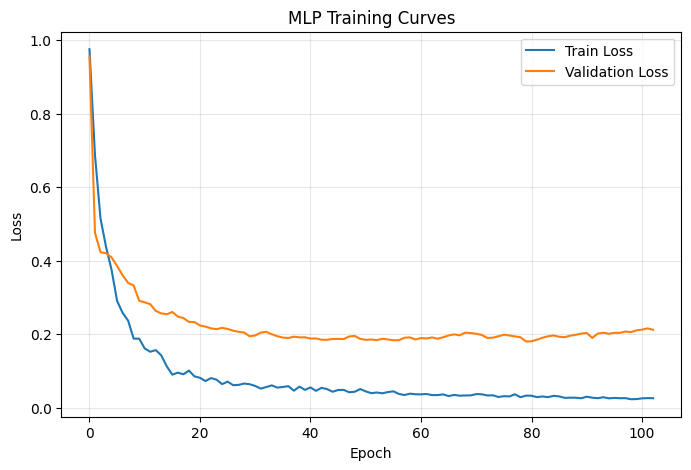

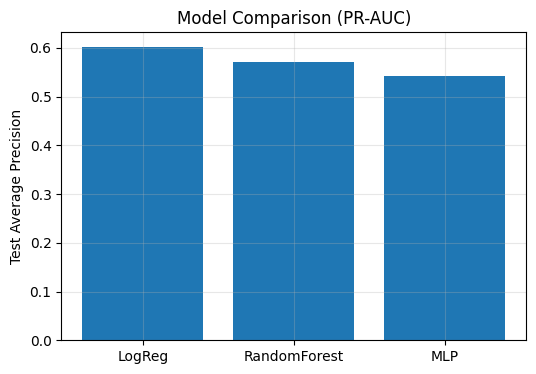

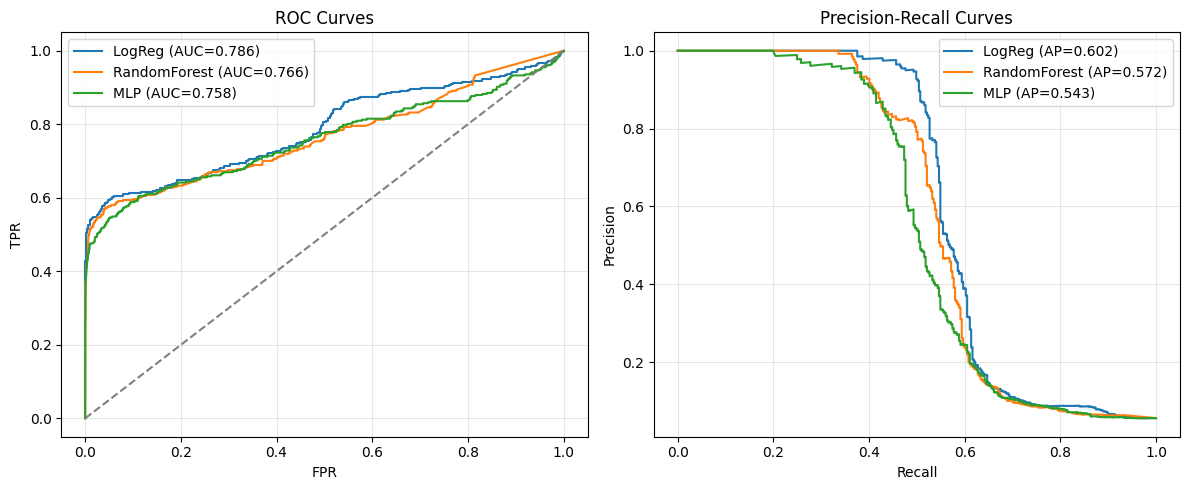

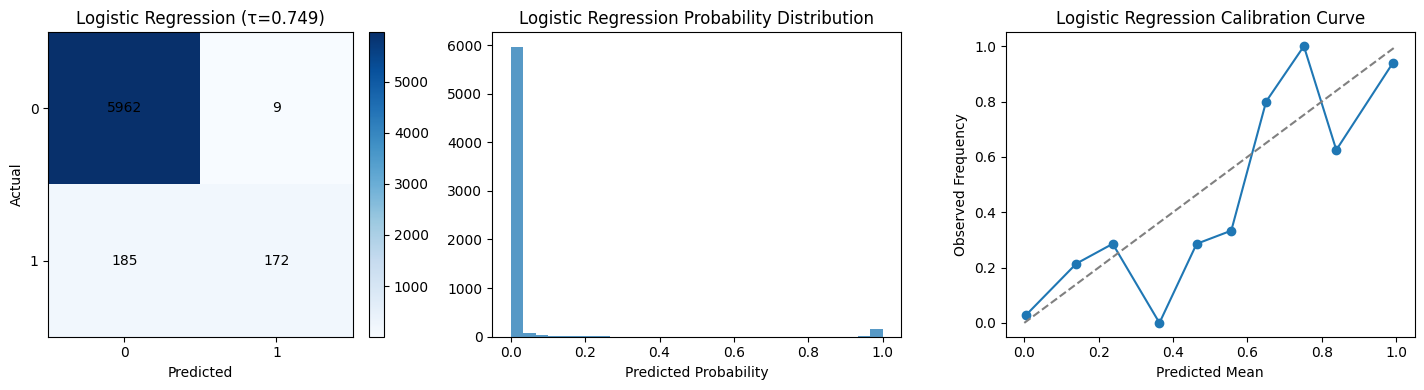

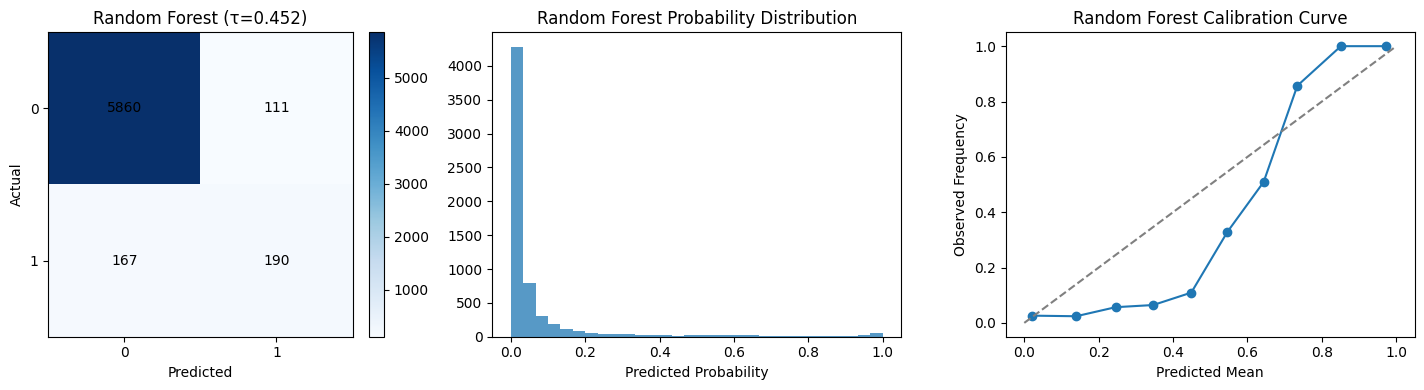

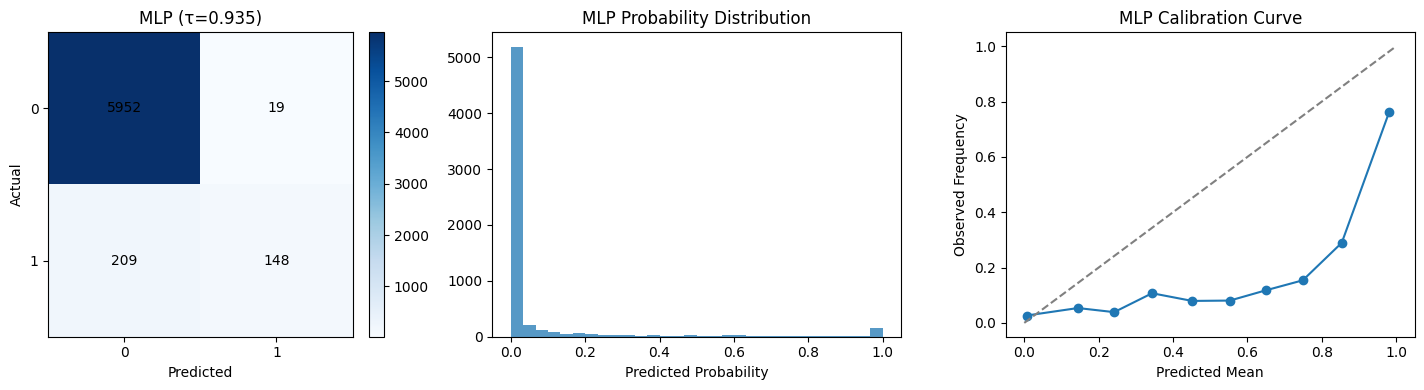

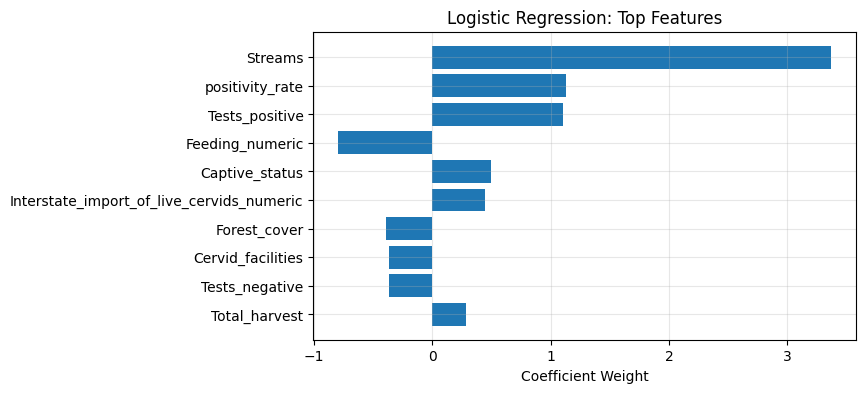

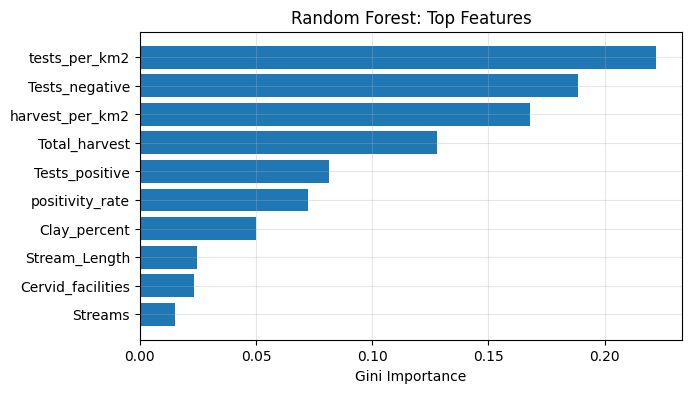

Could not compute MLP permutation importance: The 'estimator' parameter of permutation_importance must be an object implementing 'fit'. Got CWDRiskMLPImproved(
  (fc1): Linear(in_features=25, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
  (drop): Dropout(p=0.2, inplace=False)
) instead.


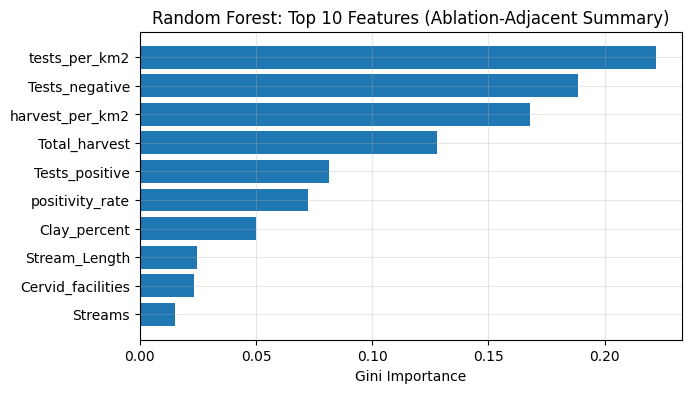

All final-deliverable visualizations generated.


In [11]:
def plot_confusion(ax, cm, title):
    im = ax.imshow(cm, cmap="Blues")
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(["0", "1"])
    ax.set_yticklabels(["0", "1"])

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j], ha="center", va="center", color="black")

    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)


# Simple feature importance visualizers
def feature_importance_logreg(model, X, title):
    if hasattr(model, "coef_"):
        coefs = model.coef_.ravel()
        idx = np.argsort(np.abs(coefs))[::-1][:10]
        plt.figure(figsize=(7, 4))
        plt.barh(X.columns[idx], coefs[idx])
        plt.gca().invert_yaxis()
        plt.title(title)
        plt.xlabel("Coefficient Weight")
        plt.grid(alpha=0.3)
        plt.show()
    else:
        print("Logistic regression model has no coefficients.")


def feature_importance_rf(model, X, title):
    if hasattr(model, "feature_importances_"):
        imp = model.feature_importances_
        idx = np.argsort(imp)[::-1][:10]
        plt.figure(figsize=(7, 4))
        plt.barh(X.columns[idx], imp[idx])
        plt.gca().invert_yaxis()
        plt.title(title)
        plt.xlabel("Gini Importance")
        plt.grid(alpha=0.3)
        plt.show()
    else:
        print("Random forest model missing feature_importances_ attribute.")


def feature_importance_mlp(model, X, y, title):
    from sklearn.inspection import permutation_importance
    try:
        result = permutation_importance(
            model,
            X,
            y,
            n_repeats=10,
            random_state=42,
            scoring="average_precision"
        )
        imp = result.importances_mean
        idx = np.argsort(imp)[::-1][:10]
        plt.figure(figsize=(7, 4))
        plt.barh(X.columns[idx], imp[idx])
        plt.gca().invert_yaxis()
        plt.title(title)
        plt.xlabel("Permutation Importance")
        plt.grid(alpha=0.3)
        plt.show()
    except Exception as e:
        print("Could not compute MLP permutation importance:", e)


#MLP Training Curves
try:
    plt.figure(figsize=(8, 5))
    plt.plot(mlp_train_losses, label="Train Loss")
    plt.plot(mlp_val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("MLP Training Curves")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()
except Exception as e:
    print("Training curves not available. If you logged train/val loss, "
          "add them as mlp_train_losses and mlp_val_losses.")
    print("Error:", e)


#Model performance side-by-side comparison
model_names = ["LogReg", "RandomForest", "MLP"]
test_ap = [
    average_precision_score(y_test, y_test_prob_lr),
    average_precision_score(y_test, y_test_prob_rf),
    average_precision_score(y_test, y_test_prob_mlp),
]

plt.figure(figsize=(6, 4))
plt.bar(model_names, test_ap)
plt.ylabel("Test Average Precision")
plt.title("Model Comparison (PR-AUC)")
plt.grid(alpha=0.3)
plt.show()


# ROC + PR Curves for all models side-by-side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ROC
for name, probs in zip(
    model_names,
    [y_test_prob_lr, y_test_prob_rf, y_test_prob_mlp]
):
    fpr, tpr, _ = roc_curve(y_test, probs)
    auc = roc_auc_score(y_test, probs)
    axes[0].plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")

axes[0].plot([0, 1], [0, 1], linestyle="--", color="gray")
axes[0].set_title("ROC Curves")
axes[0].set_xlabel("FPR")
axes[0].set_ylabel("TPR")
axes[0].legend()
axes[0].grid(alpha=0.3)

# PR
for name, probs in zip(
    model_names,
    [y_test_prob_lr, y_test_prob_rf, y_test_prob_mlp]
):
    prec, rec, _ = precision_recall_curve(y_test, probs)
    ap = average_precision_score(y_test, probs)
    axes[1].plot(rec, prec, label=f"{name} (AP={ap:.3f})")

axes[1].set_title("Precision-Recall Curves")
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


#Threshold extraction for all models 
tau_logreg = taus.get("LogReg (scaled)", 0.5)
tau_rf = taus.get("Random Forest", 0.5)
tau_mlp = taus.get("MLP (scaled)", 0.5)


# Model-specific visuals
def full_model_visuals(model_name, probs, tau):
    preds = (probs >= tau).astype(int)
    cm = confusion_matrix(y_test, preds)

    fig, axs = plt.subplots(1, 3, figsize=(15, 4))

    # Confusion
    plot_confusion(axs[0], cm, f"{model_name} (τ={tau:.3f})")

    # Probability histogram
    axs[1].hist(probs, bins=30, alpha=0.75)
    axs[1].set_title(f"{model_name} Probability Distribution")
    axs[1].set_xlabel("Predicted Probability")

    # Calibration Curve
    true_means = []
    pred_means = []
    bins = np.linspace(0, 1, 11)
    for i in range(len(bins) - 1):
        mask = (probs >= bins[i]) & (probs < bins[i + 1])
        if mask.sum() > 0:
            true_means.append(y_test[mask].mean())
            pred_means.append(probs[mask].mean())

    axs[2].plot(pred_means, true_means, marker="o")
    axs[2].plot([0, 1], [0, 1], "--", color="gray")
    axs[2].set_title(f"{model_name} Calibration Curve")
    axs[2].set_xlabel("Predicted Mean")
    axs[2].set_ylabel("Observed Frequency")

    plt.tight_layout()
    plt.show()


#Run for all three models 
full_model_visuals("Logistic Regression", y_test_prob_lr, tau_logreg)
full_model_visuals("Random Forest", y_test_prob_rf, tau_rf)
full_model_visuals("MLP", y_test_prob_mlp, tau_mlp)

#Feature Importance Visuals
feature_importance_logreg(
    logreg_model, X_test, "Logistic Regression: Top Features"
)
feature_importance_rf(
    rf_model, X_test, "Random Forest: Top Features"
)
feature_importance_mlp(
    mlp_model, X_test, y_test.to_numpy(),
    "MLP: Top Features (Permutation)"
)

#Random Forest Ablation Summary
imp = rf_model.feature_importances_
idx = np.argsort(imp)[::-1][:10]

plt.figure(figsize=(7, 4))
plt.barh(X_test.columns[idx], imp[idx])
plt.gca().invert_yaxis()
plt.title("Random Forest: Top 10 Features (Ablation-Adjacent Summary)")
plt.xlabel("Gini Importance")
plt.grid(alpha=0.3)
plt.show()

print("All final-deliverable visualizations generated.")



In [12]:
pip freeze > requirements.txt


Note: you may need to restart the kernel to use updated packages.
